In [7]:
from livelossplot import PlotLosses
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose

#!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
#!unzip -n mnist_rotation_new.zip -d mnist_rotation_new
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
class MLP2(nn.Module):
    
    def __init__(self, input_size, h1, h2, output_size):
        super(MLP2, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(in_features = input_size, out_features = h1)
        self.fc2 = nn.Linear(in_features = h1, out_features = h2)
        self.output = nn.Linear(in_features = h2, out_features = output_size)    
    
    def forward(self, x):
        out = F.relu(self.fc1(x.view(-1, self.input_size)))
        out = F.relu(self.fc2(out))
        return self.output(out)

class LeNet5(torch.nn.Module):
     
    def __init__(self):   
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(16*5*5, 120) 
        self.fc2 = torch.nn.Linear(120, 84)      
        self.fc3 = torch.nn.Linear(84, 10)   
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*5*5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=10):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn_escnn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn_escnn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn_escnn.SequentialModule(
            nn_escnn.MaskModule(in_type, 29, margin=1),
            nn_escnn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn_escnn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn_escnn.SequentialModule(
            nn_escnn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn_escnn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn_escnn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn_escnn.SequentialModule(
            nn_escnn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn_escnn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn_escnn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn_escnn.InnerBatchNorm(out_type),
            nn_escnn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn_escnn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = nn_escnn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn_escnn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [5]:
class MnistRotDataset(Dataset):
    
    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']
            
        if mode == "train":
            file = "~/data/mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "~/data/mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"
        
        self.transform = transform

        data = np.loadtxt(os.path.expanduser(file), delimiter=' ')
            
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image, mode='F')
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    def split(self, val_ratio):
        val = deepcopy(self)
        total = self.num_samples
        indices = np.random.shuffle(range(total))
        val.images = val.images[indices[:val_ratio*total]]
        

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

def test_model(model: torch.nn.Module, x: Image):
    np.set_printoptions(linewidth=10000)
    
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()
    
    x = resize1(pad(x))
    
    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            x_transformed = totensor(resize2(x.rotate(r*45., Image.Resampling.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print('##########################################################################################')
    print()


In [14]:
raw_mnist_test = MnistRotDataset(mode='test')

x, y = next(iter(raw_mnist_test))

#test_model(model, x)

train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180., resample=Image.BILINEAR, expand=False),
    resize2,
    totensor,
])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)

shuffle_dataset = True
random_seed= 42
validation_split = .2
dataset_size = mnist_train.num_samples
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
val_indices, train_indices = indices[split:], indices[:split]
print(len(val_indices), len(train_indices))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

#train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64,
                                                sampler=valid_sampler)

test_transform = Compose([
    pad,
    totensor,
])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()

epochs = 30

In [ ]:
def train(model, optimizer, train_loader=train_loader, validation_loader=validation_loader, loss_function=loss_function, epochs=epochs):
    liveloss = PlotLosses()
    dataloaders = {
        "train": train_loader,
        "validation": validation_loader
    }

    for epoch in range(epochs):
        logs = {}
        for phase in ['train', 'validation']:
            print(len(dataloaders[phase].dataset))
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_count = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_count += inputs.size(0)

            epoch_loss = running_loss / running_count
            epoch_acc = running_corrects.float() / running_count
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

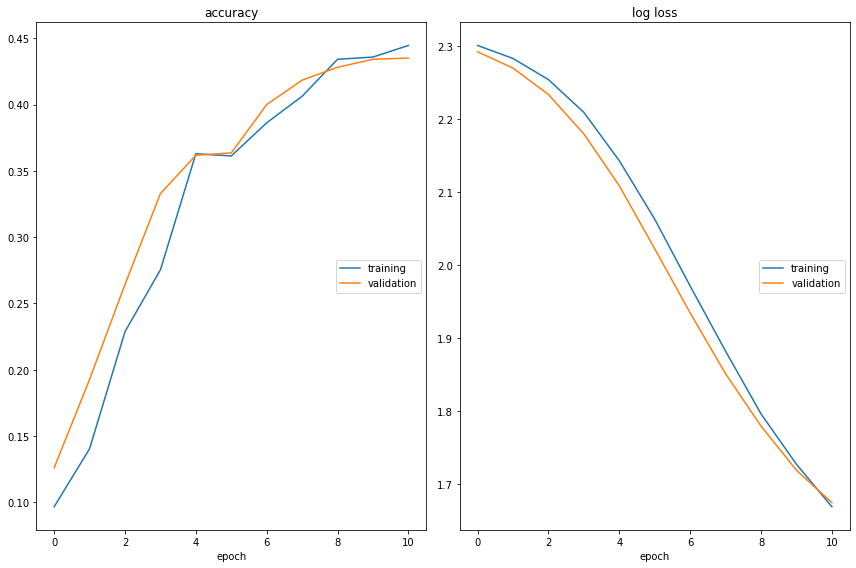

accuracy
	training         	 (min:    0.097, max:    0.445, cur:    0.445)
	validation       	 (min:    0.126, max:    0.435, cur:    0.435)
log loss
	training         	 (min:    1.669, max:    2.301, cur:    1.669)
	validation       	 (min:    1.674, max:    2.293, cur:    1.674)
12000
12000


In [23]:
model = MLP2(input_size=1*1*29*29, h1=300, h2=100, output_size=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) #, weight_decay=1e-5)

train(model, optimizer)

In [ ]:
model = LeNet5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) #, weight_decay=1e-5)

train(model, optimizer)

NameError: name 'train' is not defined

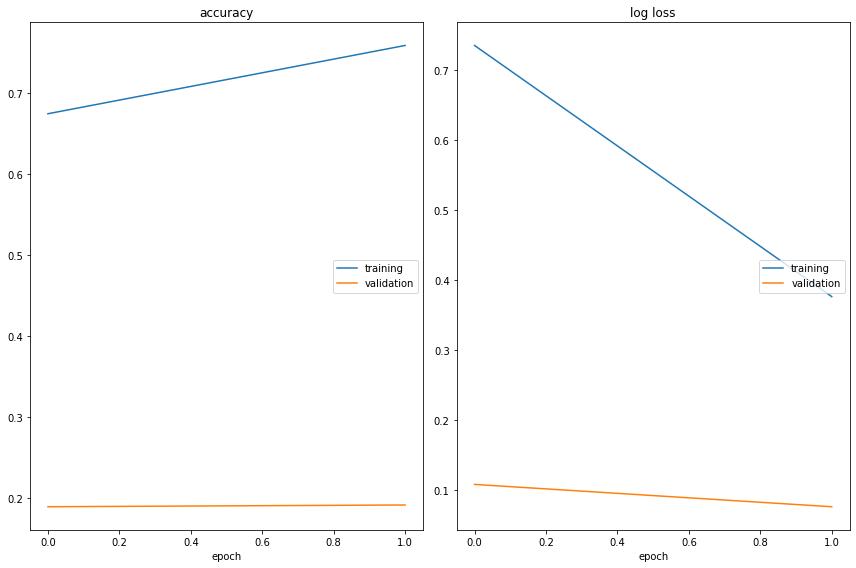

accuracy
	training         	 (min:    0.675, max:    0.759, cur:    0.759)
	validation       	 (min:    0.189, max:    0.191, cur:    0.191)
log loss
	training         	 (min:    0.376, max:    0.735, cur:    0.376)
	validation       	 (min:    0.076, max:    0.108, cur:    0.076)


In [ ]:
from escnn import gspaces
from escnn import nn as nn_escnn

model = C8SteerableCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) #, weight_decay=1e-5)

train(model, optimizer)